# **Libraries**

In [3]:
# pip install googletrans==4.0.0-rc1 # to translate to English (will be used later)
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor as rfr
import warnings
warnings.filterwarnings("ignore")
from googletrans import Translator

# **Data Cleaning**

In [5]:
# I've imported all the files we'll be needing for this project 
cities = pd.read_csv('capital_cities.csv')
ghEmission = pd.read_csv('greenhouse_emission.csv')
riskIndex = pd.read_csv('world_risk_index.csv')

In [6]:
# Here we want to merge 2 dataframes (ghEmission & cities). 
# 'country' is the primary (foriegn) index and both dataframes are merged after comparing the country names. 
# Countries that were not common in both dataframes were dropped along with the null values. 

ghEmission = ghEmission.sort_values('country', ascending=True)
ghEmission.rename(columns = {'country' : 'country1'}, inplace=True)
cities = cities.sort_values('country', ascending=True)

mergedDf = cities.merge(ghEmission, how='left', left_on='country', right_on='country1')

mergedDf = mergedDf.dropna()
mergedDf = mergedDf.drop(['country1'],axis=1).drop(['continent'],axis=1)


# Columns renamed
mergedDf.rename(columns = {'country':'Country', 'capital_city':'Capital City', 
                           'capital_population':'Capital Population', 'total_co2': 'Total CO2', 
                           'co2_per_capita': 'CO2 Per Capita', 'total_methane': 'Total Methane', 
                           'methane_per_capita': 'Methane Per Capita'}, inplace=True)

mergedDf.set_index('Country')
mergedDf.reset_index(drop=True)
mergedDf.index = np.arange(1, len(mergedDf)+1)

mergedDf

,Country,Capital City,Capital Population,Total CO2,CO2 Per Capita,Total Methane,Methane Per Capita
1,Afghanistan,Kabul,4601789,6.08 m t,0.15 t,16.37 m t,0.41 t
2,Albania,Tirana,418495,4.83 m t,1.72 t,2.85 m t,1.01 t
3,Algeria,Algiers,2712944,171.25 m t,3.84 t,92.34 m t,2.07 t
4,Argentina,Buenos Aires,2891082,168.10 m t,3.67 t,128.80 m t,2.81 t
5,Australia,Canberra,411667,386.53 m t,15.02 t,126.07 m t,4.90 t
...,...,...,...,...,...,...,...
96,United Kingdom,London,8961989,348.92 m t,5.18 t,50.11 m t,0.74 t
97,United States,"Washington, D.C.",724342,4.82 bn t,14.52 t,744.51 m t,2.24 t
98,Venezuela,Caracas,2245744,112.34 m t,3.91 t,119.24 m t,4.15 t
99,Vietnam,Hanoi,4678198,336.49 m t,3.43 t,80.48 m t,0.82 t


In [7]:
# remove string units and convert values to int data type
# We need to convert 'bn t' to 'm t' and remove the units from the string values.


list = [['Total CO2', 'Total CO2 Unit'], ['CO2 Per Capita', 'CO2 Per Capita Unit'], 
        ['Total Methane', 'Total Methane Unit'], ['Methane Per Capita', 'Methane Per Capita Unit']]

for i in range(len(list)):
  
  mergedDf[list[i]] = mergedDf[list[i][0]].str.split(' ', 1, expand=True)
  mergedDf.replace('m t', 'Mt', regex=True, inplace=True)
  mergedDf.replace('bn t', 'Gt', regex=True, inplace=True)
  mergedDf.replace(',', '', regex=True, inplace=True)

  mergedDf[list[i][0]] = mergedDf[list[i][0]].astype(float)

  mergedDf[list[i][0]] = np.where(mergedDf[list[i][1]] == 'Mt',
                          mergedDf[list[i][0]].apply(lambda x: x * 1000000), mergedDf[list[i][0]])
  
  mergedDf[list[i][0]] = np.where(mergedDf[list[i][1]] == 'Gt',
                          mergedDf[list[i][0]].apply(lambda x: x * 1000000000), mergedDf[list[i][0]])

mergedDf = mergedDf.drop(columns={'Total CO2 Unit', 'CO2 Per Capita Unit', 
                                  'Total Methane Unit', 'Methane Per Capita Unit'})
mergedDf

,Country,Capital City,Capital Population,Total CO2,CO2 Per Capita,Total Methane,Methane Per Capita
1,Afghanistan,Kabul,4601789,6.080000e+06,0.15,16370000.0,0.41
2,Albania,Tirana,418495,4.830000e+06,1.72,2850000.0,1.01
3,Algeria,Algiers,2712944,1.712500e+08,3.84,92340000.0,2.07
4,Argentina,Buenos Aires,2891082,1.681000e+08,3.67,128800000.0,2.81
5,Australia,Canberra,411667,3.865300e+08,15.02,126070000.0,4.90
...,...,...,...,...,...,...,...
96,United Kingdom,London,8961989,3.489200e+08,5.18,50110000.0,0.74
97,United States,Washington D.C.,724342,4.820000e+09,14.52,744510000.0,2.24
98,Venezuela,Caracas,2245744,1.123400e+08,3.91,119240000.0,4.15
99,Vietnam,Hanoi,4678198,3.364900e+08,3.43,80480000.0,0.82


In [8]:
# riskIndex is sorted in ascending order of the Country to be consistent with mergedDf.
# I wanted to merge mergedDf and riskIndex2021 but the country names seem to be inconsistent; unable to merge them properly. hence thery're left as it is.

riskIndex = riskIndex.sort_values('Region', ascending=True)
riskIndex.index = riskIndex.reset_index()
riskIndex.index = np.arange(1, len(riskIndex) + 1)
riskIndex = riskIndex.rename(columns= {'Region':'Country'})
riskIndex2021 = riskIndex[riskIndex['Year'] == 2021].drop(columns={'Year'}) # 2021 b/c the data in mergedDf is for 2021; ensured consistency
riskIndex2021.index = np.arange(1, len(riskIndex2021) + 1)
riskIndex2021

,Country,WRI,Exposure,Vulnerability,Susceptibility,Lack of Coping Capabilities,Lack of Adaptive Capacities,Exposure Category,WRI Category,Vulnerability Category,Susceptibility Category
1,Afghanistan,8.18,12.27,66.63,48.57,91.40,59.93,Medium,High,Very High,Very High
2,Albanien,8.23,19.77,41.63,20.10,74.77,30.03,Very High,High,Low,Low
3,Algerien,7.66,16.61,46.14,22.24,76.81,39.36,High,Medium,Medium,Medium
4,Angola,10.28,15.61,65.86,52.89,86.89,57.80,High,High,Very High,Very High
5,Antigua und Barbuda,27.28,67.73,40.28,23.80,64.41,32.62,Very High,Very High,Low,Medium
...,...,...,...,...,...,...,...,...,...,...,...
177,Zypern,3.21,8.97,35.78,15.24,67.63,24.46,Very Low,Very Low,Low,Very Low
178,Ägypten,1.82,3.76,48.33,22.22,83.15,39.62,Very Low,Very Low,High,Medium
179,Äquatorialguinea,7.29,12.73,57.28,40.64,86.57,44.64,Medium,Medium,High,High
180,Äthiopien,7.93,11.75,67.52,56.76,87.35,58.45,Low,High,Very High,Very High


In [9]:
# Solution for inconsistent country names found.
# Translating Country names from French to English
# takes some time to run 

translator = Translator()
riskIndex2021['translated_country'] = riskIndex2021['Country'].apply(lambda x: translator.translate(x, dest='en').text)

In [10]:
riskIndex2021New = riskIndex2021.loc[:,['translated_country','Country','WRI','Exposure','Vulnerability',
                                        'Susceptibility','Lack of Coping Capabilities',' Lack of Adaptive Capacities',
                                        'Exposure Category','WRI Category','Vulnerability Category','Susceptibility Category']]

In [11]:
riskIndex2021New = riskIndex2021New.drop(columns='Country')
riskIndex2021New.rename(columns = {'translated_country':'Country1'}, inplace = True)

In [12]:
# Final WRI Dataframe after data cleaning
riskIndex2021New.sort_values('Country1', ascending=True)
riskIndex2021New['Country1'] = riskIndex2021New['Country1'].str.replace('Ver.States of America','United States') 

In [13]:
FinalDf = mergedDf.merge(riskIndex2021New, how='left', left_on='Country', right_on='Country1')

### Final Dataframe (cleaned and merged)

In [14]:
FinalDf = FinalDf.dropna()
FinalDf.drop(columns={'Country1'})

,Country,Capital City,Capital Population,Total CO2,CO2 Per Capita,Total Methane,Methane Per Capita,WRI,Exposure,Vulnerability,Susceptibility,Lack of Coping Capabilities,Lack of Adaptive Capacities,Exposure Category,WRI Category,Vulnerability Category,Susceptibility Category
0,Afghanistan,Kabul,4601789,6.080000e+06,0.15,16370000.0,0.41,8.18,12.27,66.63,48.57,91.40,59.93,Medium,High,Very High,Very High
1,Albania,Tirana,418495,4.830000e+06,1.72,2850000.0,1.01,8.23,19.77,41.63,20.10,74.77,30.03,Very High,High,Low,Low
2,Algeria,Algiers,2712944,1.712500e+08,3.84,92340000.0,2.07,7.66,16.61,46.14,22.24,76.81,39.36,High,Medium,Medium,Medium
3,Argentina,Buenos Aires,2891082,1.681000e+08,3.67,128800000.0,2.81,3.52,9.60,36.63,20.35,60.27,29.27,Low,Low,Low,Low
4,Australia,Canberra,411667,3.865300e+08,15.02,126070000.0,4.90,4.54,18.07,25.12,15.66,43.67,16.02,High,Low,Very Low,Very Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,United Kingdom,London,8961989,3.489200e+08,5.18,50110000.0,0.74,3.51,12.58,27.92,16.18,48.71,18.87,Medium,Low,Very Low,Very Low
96,United States,Washington D.C.,724342,4.820000e+09,14.52,744510000.0,2.24,3.98,13.03,30.58,15.92,54.15,21.68,Medium,Low,Very Low,Very Low
97,Venezuela,Caracas,2245744,1.123400e+08,3.91,119240000.0,4.15,7.99,16.02,49.86,25.75,86.35,37.47,High,High,High,Medium
98,Vietnam,Hanoi,4678198,3.364900e+08,3.43,80480000.0,0.82,10.27,22.04,46.60,23.73,76.73,39.34,Very High,High,Medium,Medium


Exposure here means exposure to earthquakes, cyclones,
floods, drought, and sea-level rise

Susceptibility is a variable that is derived from  infrastructure, food supply, and economic framework conditions

Coping capacities is a variable that depends on governance, health care and social security

Adaptive capacities is a variable derived from the probability of upcoming natural events and  climate change

WRI is a variable that is derived from the abovementioned features

# **Exploratory Data Analysis (EDA)**

[Text(0.5, 1.0, 'Top 20 WRI Countries in 2021')]

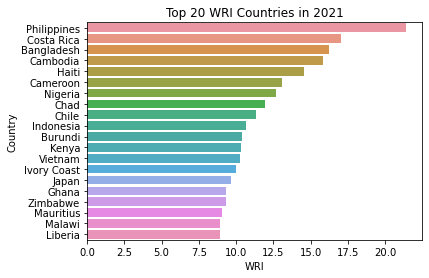

In [18]:
# Plotting Countires with Highest WRI (Usman)
new_df = FinalDf[['Country', 'WRI' ]].sort_values('WRI', ascending=False).head(20)
sns.barplot(data=new_df, y='Country', x='WRI').set(title='Top 20 WRI Countries in 2021')

We see a trend most of these are developing/undeveloped countries which are at the highest risk

[Text(0.5, 1.0, 'Top 20 Vulnerable Countries in 2021')]

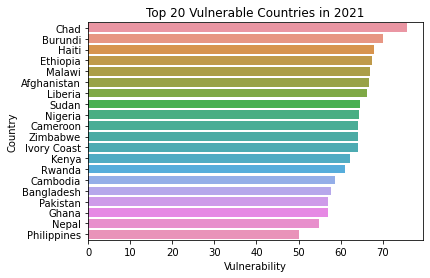

In [19]:
# plotting highest vulnerable countries to see a trend
new_df = FinalDf[['Country', 'Vulnerability' ]].sort_values('Vulnerability', ascending=False).head(20)
sns.barplot(data=new_df, y='Country', x='Vulnerability').set(title='Top 20 Vulnerable Countries in 2021')

Most vulnerable countries here are again developing/undeveloped countries

[Text(0.5, 1.0, 'Top 20 Countries unable to cope with natural disasters in 2021')]

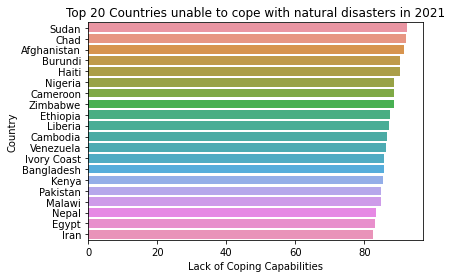

In [20]:
# plotting highest lack of coping capabilities countries to see a trend
new_df = FinalDf[['Country', 'Lack of Coping Capabilities' ]].sort_values('Lack of Coping Capabilities', ascending=False).head(20)
sns.barplot(data=new_df, y='Country', x='Lack of Coping Capabilities').set(title='Top 20 Countries unable to cope with natural disasters in 2021')

Poor countries are unable to cope with natural disaters despite of not being in the top most CO2 emission list

[Text(0.5, 1.0, 'Top 20 CO2 Producing Countries in 2021')]

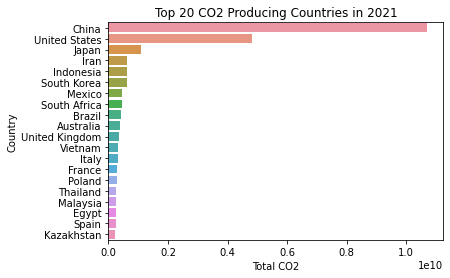

In [21]:
# Bar plot of top CO2 producing countries 
new_df = FinalDf[['Country', 'Total CO2' ]].sort_values('Total CO2', ascending=False).head(20)
sns.barplot(data=new_df, y='Country', x='Total CO2').set(title='Top 20 CO2 Producing Countries in 2021')

[Text(0.5, 1.0, 'Top 20 Methane Producing Countries in 2021')]

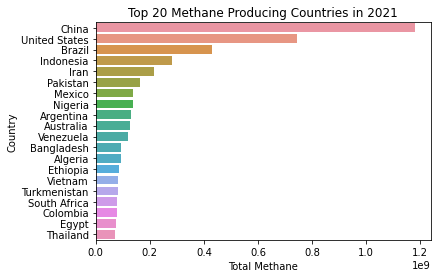

In [22]:
# Bar plot of top Methane producing countries 
new_df2 = FinalDf[['Country', 'Total Methane' ]].sort_values('Total Methane', ascending=False).head(20)
sns.barplot(data=new_df2, y='Country', x='Total Methane').set(title='Top 20 Methane Producing Countries in 2021')

[Text(0.5, 1.0, 'Top 20 Countries With Highest Capital Population in 2021')]

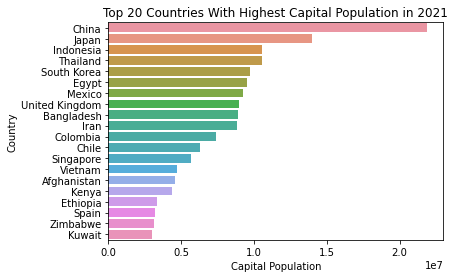

In [25]:
new_df3 = FinalDf[['Country', 'Capital Population']].sort_values('Capital Population', ascending=False).head(20)
sns.barplot(data=new_df3, y='Country', x='Capital Population').set(title='Top 20 Countries With Highest Capital Population in 2021')

[Text(0.5, 1.0, 'Top 20 Countries With Lowest Capital Population in 2021')]

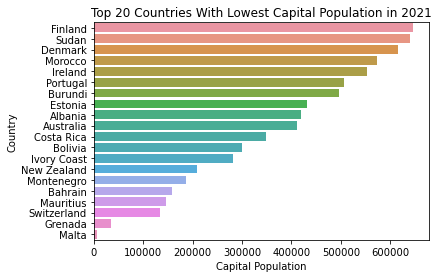

In [26]:
new_df4 = FinalDf[['Country', 'Capital Population']].sort_values('Capital Population', ascending=False).tail(20)
sns.barplot(data=new_df4, y='Country', x='Capital Population').set(title='Top 20 Countries With Lowest Capital Population in 2021')

Correlation matrix for mergedDf

<AxesSubplot:>

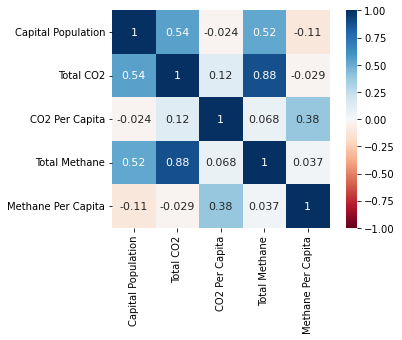

In [27]:
corr = mergedDf.corr()
sns.heatmap(corr, cmap='RdBu', vmin=-1, vmax=1, annot=True, 
            annot_kws={'fontsize':11}, square=True)

Correlation matrix for riskIndex for the year 2021

<AxesSubplot:>

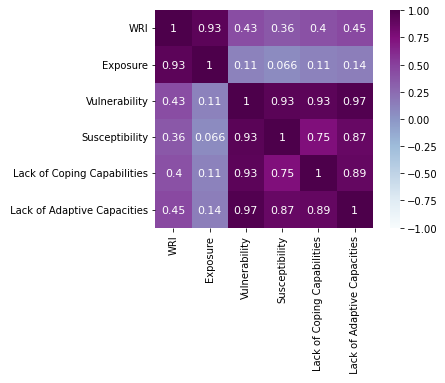

In [28]:
corr2 = riskIndex2021.corr()
sns.heatmap(corr2, cmap='BuPu', vmin=-1, vmax=1, annot=True, 
            annot_kws={'fontsize':11}, square=True)

Boxplot

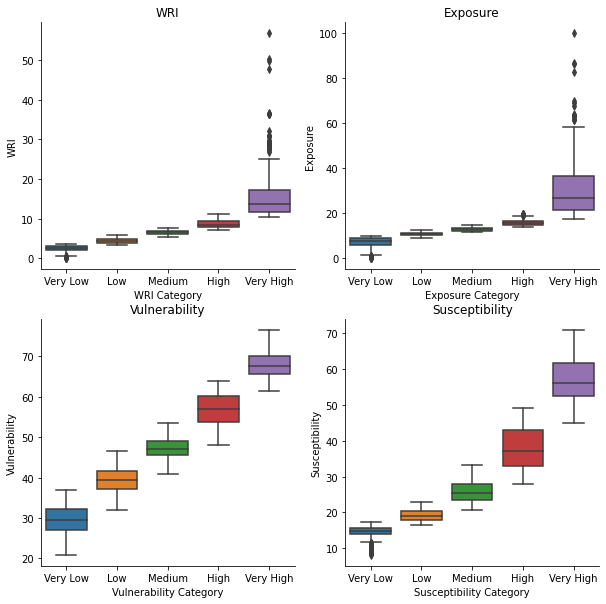

In [30]:
# boxplotting each category (very low, low, medium etc) of every variable against the variable, in riskindex dataset.
y = ['WRI','Exposure','Vulnerability','Susceptibility']
fig, ((a,b),(c,d)) = plt.subplots (2, 2, figsize=(10, 10))
for i,j in zip(y,[a,b,c,d]):
    sns.boxplot(x=i+' Category', y=i,data=riskIndex.sort_values(by=i), ax=j)
    j.set_title(i)
sns.despine()

Scatterplot

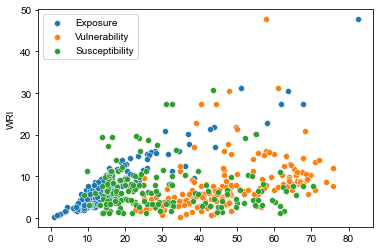

In [31]:
sns.scatterplot(riskIndex2021['Exposure'], riskIndex2021['WRI'], label="Exposure").set(xlabel=None) 
sns.scatterplot(riskIndex2021['Vulnerability'], riskIndex2021['WRI'], label="Vulnerability").set(xlabel=None) 
sns.scatterplot(riskIndex2021['Susceptibility'], riskIndex['WRI'], label="Susceptibility").set(xlabel=None) 
plt.legend()
sns.set(rc={'figure.figsize':(10,10)})
plt.show()

A linear relation can be observed for Exposure and Vulnerability wrt WRI.

## **Machine Learning**

After analyzing the data, the first insight was to predict the WRI of a country
based on the various factors provided in the WRI Dataframe. This will be done by
raining our ML model on 70–80% of the data and predicting the WRI of the rest (20-30%) of data.

In [34]:
#[saif]
# create linear regression object
MLR = LinearRegression()

train_df, test_df = train_test_split(riskIndex2021, random_state=100, train_size=0.70, shuffle=True)
train_X = train_df[['Exposure','Vulnerability','Susceptibility']]
train_Y = train_df['WRI']

test_X = test_df[['Exposure','Vulnerability','Susceptibility']]
test_Y = test_df['WRI']

# fit linear regression
MLR.fit(train_X,train_Y)

predictedWRI = MLR.predict([[12.27,66.63,48.57]]) #took random values of variables and preicted the corresponding WRI (for Afghanistan)
print(predictedWRI) # -> 8.88, actual value is 8.18
# error is 0.7

# if we train the model on 3 features ('Exposure','Vulnerability','Susceptibility') to predict WRI, it overpredicts the WRI value because 
# there is correlation within our controlled variables (we may need to add or omit variables in our model)

[8.88827342]


In [35]:
def RMSE_calc(y, y_hat):
    return np.sqrt(mean_squared_error(y, y_hat))

train_df, test_df = train_test_split(riskIndex2021 , random_state=100, train_size=0.70, shuffle=True)
train_X = train_df[['Exposure','Vulnerability','Susceptibility']]
train_Y = train_df['WRI']

test_X = test_df[['Exposure','Vulnerability','Susceptibility']]
test_Y = test_df['WRI']

X_train = sm.add_constant(train_X) 
est = sm.OLS(train_Y, X_train).fit() 

X_test = sm.add_constant(test_X)
est.params
y_hat_sm = X_test@(est.params)
sm_RMSE = RMSE_calc(test_Y, y_hat_sm)
print(sm_RMSE)

1.004114196662138


In [36]:
list = ['Exposure','Vulnerability','Susceptibility']

train_df, test_df = train_test_split(riskIndex2021, random_state=100, train_size=0.70, shuffle=True)

train_X = train_df.loc[:, list]
train_y = train_df['WRI']

test_X = test_df.loc[:, list]
test_y = test_df['WRI']

X_train = sm.add_constant(train_X) 
est = sm.OLS(train_y, X_train).fit() 
est.summary()

# According to the OLS regression results our features are statistically significant

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    WRI   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     1148.
Date:                Sat, 08 Jul 2023   Prob (F-statistic):           3.32e-89
Time:                        01:50:32   Log-Likelihood:                -206.34
No. Observations:                 126   AIC:                             420.7
Df Residuals:                     122   BIC:                             432.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -7.0837      0.539    -13.136      0.000      -8.151      -6.016
Exposure           0.4809      0.009     52.860      0.000       0.463       0.499
Vulnerability      0.1534      0.022      7.050      0.000       0.110       0.196
Susceptibility    -0.0031      0.020     -0.157      0.875      -0.042       0.036
==============================================================================
Omnibus:                       34.539   Durbin-Watson:                   2.138
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              496.961
Skew:                           0.157   Prob(JB):                    1.22e-108
Kurtosis:                      12.724   Cond. No.                         299.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
est.params
X_test = sm.add_constant(test_X)
y_hat = X_test@(est.params)
RMSE = RMSE_calc(test_y, y_hat)
print('MLR RMSE = ', RMSE)

MLR RMSE =  1.004114196662138


In [41]:
rfrmodel = rfr(max_depth = 25, n_estimators = 20, random_state = 15)
rfrmodel.fit(train_X, train_y)
rfr_y_hat = rfrmodel.predict(test_X)
rfr_RMSE = RMSE_calc(test_y, rfr_y_hat)
print('Random forest RMSE = ', rfr_RMSE)
print('Random forest prediction =', rfrmodel.predict([[12.27, 66.63, 48.57]])[0])

Random forest RMSE =  0.9823026403673801
Random forest prediction = 8.210500000000001


Actual WRI value = 8.18
Random forest predicted WRI = 8.21 , error = 0.03
OLS MLR predicted WRI = 8.67, error = 0.49

More generally:
MLR RMSE =  1.004
Random forest RMSE =  0.982

#### Among a (i) 70/30, (ii) 80/20 & (iii) 90/10 train-test split 
#### **70/30 gave the lowest root mean squared error**, therefore we will consider the 70/30 split.

# **Causal Inference**

In [45]:
last_df = FinalDf[['Country','WRI','CO2 Per Capita','Methane Per Capita']]
last_df

,Country,WRI,CO2 Per Capita,Methane Per Capita
0,Afghanistan,8.18,0.15,0.41
1,Albania,8.23,1.72,1.01
2,Algeria,7.66,3.84,2.07
3,Argentina,3.52,3.67,2.81
4,Australia,4.54,15.02,4.90
...,...,...,...,...
95,United Kingdom,3.51,5.18,0.74
96,United States,3.98,14.52,2.24
97,Venezuela,7.99,3.91,4.15
98,Vietnam,10.27,3.43,0.82


In [46]:
FinalDf['CO2 Per Capita'].describe()

count    81.000000
mean      4.781975
std       4.531938
min       0.060000
25%       1.310000
50%       3.870000
75%       7.110000
max      21.400000
Name: CO2 Per Capita, dtype: float64

In [47]:
# Making a new treatment variable column where treatment = 1 when 
# CO2 emissions per capita are greater than the median level (3.89) 

last_df['Treatment CO2 per capita'] = np.where(last_df['CO2 Per Capita'] > 3.89, 1, 0)

In [48]:
FinalDf['Methane Per Capita'].describe()

count    81.000000
mean      1.738889
std       2.737863
min       0.070000
25%       0.670000
50%       0.880000
75%       1.500000
max      18.050000
Name: Methane Per Capita, dtype: float64

In [49]:
# Making a new treatment variable column where treatment = 1 when 
# methane emissions per capita are greater than the median level (0.86)

last_df['Treatment Methane per capita'] = np.where(last_df['CO2 Per Capita'] > 0.86, 1, 0)
last_df

,Country,WRI,CO2 Per Capita,Methane Per Capita,Treatment CO2 per capita,Treatment Methane per capita
0,Afghanistan,8.18,0.15,0.41,0,0
1,Albania,8.23,1.72,1.01,0,1
2,Algeria,7.66,3.84,2.07,0,1
3,Argentina,3.52,3.67,2.81,0,1
4,Australia,4.54,15.02,4.90,1,1
...,...,...,...,...,...,...
95,United Kingdom,3.51,5.18,0.74,1,1
96,United States,3.98,14.52,2.24,1,1
97,Venezuela,7.99,3.91,4.15,1,1
98,Vietnam,10.27,3.43,0.82,0,1


In [50]:
CO2_Per_Capita_ATE = last_df.loc[last_df['Treatment CO2 per capita'] == 1, 'WRI'].mean() \
                     - last_df.loc[last_df['Treatment CO2 per capita'] == 0, 'WRI'].mean()

CO2_Per_Capita_ATE

-4.021579268292684

In [51]:
Methane_Per_Capita_ATE = last_df.loc[last_df['Treatment Methane per capita'] == 1, 'WRI'].mean() \
                         - last_df.loc[last_df['Treatment Methane per capita'] == 0, 'WRI'].mean()

Methane_Per_Capita_ATE

-4.341746031746035

In [52]:
# Making a new treatment variable column where treatment = 1 when CO2 emissions per capita are greater than the 25th percentile (1.37)

last_df['Treatment CO2 per capita 1'] = np.where(last_df['CO2 Per Capita'] > 1.37, 1, 0)
CO2_Per_Capita_ATE_1 = last_df.loc[last_df['Treatment CO2 per capita 1'] == 1, 'WRI'].mean() \
                       - last_df.loc[last_df['Treatment CO2 per capita 1'] == 0, 'WRI'].mean()

CO2_Per_Capita_ATE_1

-5.514547619047619

In [53]:
# Making a new treatment variable column where treatment = 1 when Methane emissions per capita are greater than the 25th percentile (0.64)

last_df['Treatment Methane per capita 1'] = np.where(last_df['CO2 Per Capita'] > 0.64, 1, 0)
Methane_Per_Capita_ATE_1 = last_df.loc[last_df['Treatment Methane per capita 1'] == 1, 'WRI'].mean() \
                           - last_df.loc[last_df['Treatment Methane per capita 1'] == 0, 'WRI'].mean()

Methane_Per_Capita_ATE_1

-4.505326923076924

In our causal inference findings, we have established that the higher the per capita greenhouse emissions of a country are, the lower is its WRI index.

This means that the countries which contribute the highest to climate change are at a lower risk and less likely to face its detrimental consequences. 

This can be explained by an array of factors such as the fact that countries with higher emissions are mostly developed that are better suited to deal with the consequences of higher emissions.   